# Analyze RAGIS ensmbles

In [1]:
from datetime import datetime
import numpy as np
import pylab as plt
import pandas as pd
from pathlib import Path
import os
import xarray as xr

import seaborn as sns

from pismragis.observations import load_imbie, load_mouginot, load_mankoff, plot_observations, plot_multiple_observations
from pismragis.analysis import resample_ensemble_by_data, sensitivity_analysis
from pismragis.processing import convert_netcdf_to_dataframe, check_file, copy_file, to_decimal_year
from pismragis.stats import run_stats

## Some settings

In [2]:
# Root directory
data_dir = Path("/Users/andy/Google Drive/My Drive/Projects/RAGIS/data/pism")
assert data_dir.exists()
results_dir = "2023_10_tw_ocean_calving_analyis"
o_dir = data_dir / results_dir
o_dir.mkdir(exist_ok=True)
fig_dir = o_dir / "figures"
fig_dir.mkdir(exist_ok=True)
# Number of parallel jobs
n_jobs = 4
# Normalization year (1992 IMBIE)
norm_year = 1992

In [29]:

plt.rc('font', size=6)
plt.style.use("tableau-colorblind10")

mass_varname = "Cumulative ice sheet mass change (Gt)"
mass_uncertainty_varname = "Cumulative ice sheet mass change uncertainty (Gt)"
discharge_varname = "Rate of ice discharge (Gt/yr)"
discharge_uncertainty_varname = "Rate of ice discharge uncertainty (Gt/yr)"
smb_varname = "Rate of surface mass balance (Gt/yr)"
smb_uncertainty_varname = "Rate of surface mass balance uncertainty (Gt/yr)"

bg_color = "w"
sim_colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][1::]
imbie_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]

sim_colors = [ "#d73027",  "#4575b4", "#fc8d59", "#91bfdb", "#fee090"]

imbie_color = "#756bb1"
mou_color = "#54278f"

imbie_color = "0.45"
man_color = "0.35"
mou_color = "0.25"

    
kg2cmsle = 1 / 1e12 * 1.0 / 362.5 / 10.0
gt2cmsle = 1 / 362.5 / 10.0

## Load Observations

In [30]:
# imbie = load_imbie(url=Path("/Users/andy/Google Drive/My Drive/Projects/RAGIS/data/imbie_dataset_greenland_dynamics-2020_02_28.xlsx"))
imbie = load_imbie()
# Glacier and Ice cap bias 30 Gt/yr, add it back
imbie[mass_varname] -= 30 * gt2cmsle
imbie[smb_varname] += 30

mou = load_mouginot(url=Path("/Users/andy/Google Drive/My Drive/Projects/RAGIS/data/pnas.1904242116.sd02.xlsx"), norm_year=1980)
mou_gis = mou[mou["Basin"] == "GIS"]

mou_1992 = load_mouginot(url=Path("/Users/andy/Google Drive/My Drive/Projects/RAGIS/data/pnas.1904242116.sd02.xlsx"), norm_year=1992)
mou_gis_1992 = mou_1992[mou_1992["Basin"] == "GIS"]

man = load_mankoff()


## Make a list of all experiments

In [31]:
exps = []

# exps.append({
#     "Experiment": "GrIMP",
#     "proj_dir": "2023_10_grimp_ocean_calving_w_posterior_lhs_50",
#     "scalar_dir": "scalar",
#     "processed_dir": "processed",
#     "lhs": "gris_ragis_ocean_calving_w_posterior_lhs_50",
#     "DEM": "GRIMP"
# }
# )



# exps.append({
#     "Experiment": "RAGIS",
#     "proj_dir": "2023_10_ragis_ocean_calving_w_posterior_lhs_50",
#     "scalar_dir": "scalar",
#     "processed_dir": "processed",
#     "lhs": "gris_ragis_ocean_calving_w_posterior_lhs_50",
#     "DEM": "RAGIS"
# }
# )

exps.append({
    "Experiment": "GrIMP",
    "proj_dir": "2023_10_grimp_tw_ocean_calving_w_posterior_lhs_50",
    "scalar_dir": "scalar",
    "scalar_processed_dir": "scalar_processed",
    "spatial_dir": "spatial",
    "spatial_processed_dir": "spatial_processed",
    "lhs": "gris_ragis_ocean_calving_w_posterior_lhs_50",
    "DEM": "GRIMP",
    "resolution": 900
}
)



exps.append({
    "Experiment": "RAGIS",
    "proj_dir": "2023_10_ragis_tw_ocean_calving_w_posterior_lhs_50",
    "scalar_dir": "scalar",
    "scalar_processed_dir": "scalar_processed",
    "spatial_dir": "spatial",
    "spatial_processed_dir": "spatial_processed",
    "lhs": "gris_ragis_ocean_calving_w_posterior_lhs_50",
    "DEM": "RAGIS",
    "resolution": 900
}
)


## Process experiments

In [6]:
experiments = []

for exp in exps:
    print(f"""Processing {exp["Experiment"]}""")
    print("================================================\n")
    ens_file = data_dir / exp["proj_dir"] / "uq" /f"""{exp["lhs"]}.csv"""
    s_dir = data_dir / exp["proj_dir"] / exp["scalar_dir"]
    scalar_files = sorted(s_dir.glob(f"""ts_gris_g{exp["resolution"]}m_*{exp["DEM"]}_id_*_1980-1-1_2020-1-1.nc"""))
    processed_path = data_dir / exp["proj_dir"] / exp["scalar_processed_dir"]
    for scalar_file in scalar_files:
        if check_file(scalar_file):
            copy_file(scalar_file, processed_path)
        
    processed_files = sorted(processed_path.glob(f"""ts_gris_g{exp["resolution"]}m_*{exp["DEM"]}_id_*_1980-1-1_2020-1-1.nc"""))
    exp_df = convert_netcdf_to_dataframe(processed_files, resample="yearly", verbose=False, n_jobs=n_jobs, norm_year=1980)
    exp_df["Experiment"] = exp["Experiment"]
    exp["data_df"] = exp_df
    exp["run_stats"] = run_stats(processed_files, experiment=exp["Experiment"])
    try:
        sa_df = sensitivity_analysis(exp_df.dropna(), ensemble_file=ens_file, n_jobs=n_jobs)
        exp["sensitivity_df"] = sa_df
    except:
        pass
    experiments.append(exp)


Processing GrIMP

/Users/andy/Google Drive/My Drive/Projects/RAGIS/data/pism/2023_10_grimp_tw_ocean_calving_w_posterior_lhs_50/scalar/ts_gris_g900m_v2023_GRIMP_id_16_1980-1-1_2020-1-1.nc time-series too short or not monotonically-increasing.
/Users/andy/Google Drive/My Drive/Projects/RAGIS/data/pism/2023_10_grimp_tw_ocean_calving_w_posterior_lhs_50/scalar/ts_gris_g900m_v2023_GRIMP_id_17_1980-1-1_2020-1-1.nc time-series too short or not monotonically-increasing.
/Users/andy/Google Drive/My Drive/Projects/RAGIS/data/pism/2023_10_grimp_tw_ocean_calving_w_posterior_lhs_50/scalar/ts_gris_g900m_v2023_GRIMP_id_36_1980-1-1_2020-1-1.nc time-series too short or not monotonically-increasing.
/Users/andy/Google Drive/My Drive/Projects/RAGIS/data/pism/2023_10_grimp_tw_ocean_calving_w_posterior_lhs_50/scalar/ts_gris_g900m_v2023_GRIMP_id_46_1980-1-1_2020-1-1.nc time-series too short or not monotonically-increasing.
Converting netcdf files to pandas.DataFrame
------------------------------------------

Processing files: 100%|███████████████████████████████████████████████████████████████████████████████| 28/28 [00:03<00:00,  9.09it/s]


Conversion finished in 3 seconds
-------------------------------------------
-------------------------------------------

Processing RAGIS

/Users/andy/Google Drive/My Drive/Projects/RAGIS/data/pism/2023_10_ragis_tw_ocean_calving_w_posterior_lhs_50/scalar/ts_gris_g900m_v2023_RAGIS_id_17_1980-1-1_2020-1-1.nc time-series too short or not monotonically-increasing.
/Users/andy/Google Drive/My Drive/Projects/RAGIS/data/pism/2023_10_ragis_tw_ocean_calving_w_posterior_lhs_50/scalar/ts_gris_g900m_v2023_RAGIS_id_36_1980-1-1_2020-1-1.nc time-series too short or not monotonically-increasing.
/Users/andy/Google Drive/My Drive/Projects/RAGIS/data/pism/2023_10_ragis_tw_ocean_calving_w_posterior_lhs_50/scalar/ts_gris_g900m_v2023_RAGIS_id_46_1980-1-1_2020-1-1.nc time-series too short or not monotonically-increasing.
Converting netcdf files to pandas.DataFrame
-------------------------------------------


Processing files: 100%|███████████████████████████████████████████████████████████████████████████████| 29/29 [00:02<00:00, 11.83it/s]


Conversion finished in 2 seconds
-------------------------------------------
-------------------------------------------



In [7]:
spatial_vars = ["usurf", "velsurf_mag"]

In [8]:
def select_slice(ds, start_date: str = "1985-01-01", end_date: str = "1986-01-01", variables: list = ["usurf", "velsurf_mag"]):
    return ds.sel(time=slice(start_date, end_date), x=slice(-250000, -50000), y=slice(-2300000, -2240000))[variables].mean("time")

In [9]:
# fig, axs = plt.subplots(len(exps), 1, figsize=(6.2, 6.2))
# for k, exp in enumerate(exps):
#     print(f"""Processing {exp["Experiment"]}""")
#     print("================================================\n")
#     s_dir = data_dir / exp["proj_dir"] / exp["spatial_dir"]
#     spatial_files = sorted(s_dir.glob(f"""ex_gris_g{exp["resolution"]}m_*{exp["DEM"]}_id_*_1980-1-1_2020-1-1.nc"""))
#     ds = xr.open_mfdataset(spatial_files, preprocess=select_slice, combine="nested", concat_dim="id", chunks={"id": -1, "x": 100, "y": 100}, parallel=True)
#     %time ens = ds.chunk(dict(id=-1)).quantile(0.5, "id").compute()
#     ens["velsurf_mag"].plot(ax=axs[k], cmap=cmap, norm=norm)
#     %time ds_v = ds[spatial_vars].mean(dim="time")
#     %time ensmedian = ds_v.quantile(50, "id")



In [10]:
%time ens = ds.chunk(dict(id=-1)).quantile(0.5, "id").compute()

NameError: name 'ds' is not defined

In [11]:
import matplotlib.colors as colors
speed_colormap = np.array([
    [198,227,249],
    [87,200,255],
    [0,42,255],
    [197,27,158],
    [169,19,24]]) / 255
bounds = np.array([10, 100, 250, 750, 1500]).reshape(-1, 1)
s_map = np.hstack([bounds, speed_colormap])

bounds = np.array([10, 100, 250, 750, 1500])
n_reps = (np.diff(bounds) / 10).astype("int")
speed_cmap  = np.vstack([speed_colormap[k, :].reshape(1, -1).repeat(n, axis=0) for k, n in enumerate(n_reps)])
cmap = colors.LinearSegmentedColormap.from_list("speed", speed_cmap)
cmap = colors.ListedColormap(speed_cmap, "speed")
norm = colors.Normalize(0, 1500)
# norm = colors.BoundaryNorm(bounds, 100)

In [12]:
colors.LinearSegmentedColormap?

In [13]:
np.array([[198,227,249, 255]]).repeat(3, axis=0)

array([[198, 227, 249, 255],
       [198, 227, 249, 255],
       [198, 227, 249, 255]])

## Ensemble Performance Statistics

In [14]:
m_vars = ["processor_hours", "wall_clock_hours", "model_years_per_processor_hour"]
for m, e in enumerate(experiments):
    e_df = experiments[m]["run_stats"]
    print(f"""Peformace Summary for Experiment {e["Experiment"]} ({len(e_df)} members)""")
    print("---------------------------------------------------\n")
    print(e_df.agg({'processor_hours': 'sum', 'wall_clock_hours': "sum", "model_years_per_processor_hour": "mean"}))
    print("---------------------------------------------------\n")

Peformace Summary for Experiment GrIMP (28 members)
---------------------------------------------------

processor_hours                   95358.515476
wall_clock_hours                    794.654296
model_years_per_processor_hour        0.011552
dtype: float64
---------------------------------------------------

Peformace Summary for Experiment RAGIS (29 members)
---------------------------------------------------

processor_hours                   87045.719670
wall_clock_hours                    725.380997
model_years_per_processor_hour        0.013156
dtype: float64
---------------------------------------------------



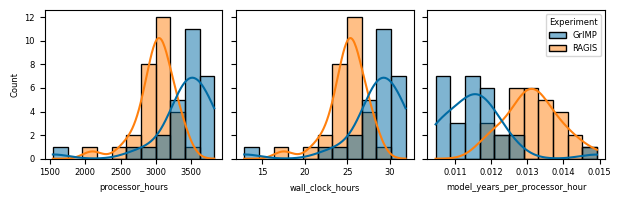

In [15]:
plt.rc('font', size=6)
plt.style.use("tableau-colorblind10")

fig, axs = plt.subplots(nrows=1, ncols=len(m_vars), sharey="row", figsize=[6.2, 2.0])
fig.subplots_adjust(wspace=0)


all_run_stats = pd.concat([experiments[k]["run_stats"] for k in range(len(experiments))]).reset_index(drop=True)
[sns.histplot(data=all_run_stats, x=m_var, bins=11, kde=True, hue="Experiment", ax=axs[k]) for k, m_var in enumerate(m_vars)]
axs[0].legend([], [], frameon=False)
axs[1].legend([], [], frameon=False)


fig.tight_layout()
run_stats_file = fig_dir / "run_stats.pdf"
fig.savefig(run_stats_file)

## Plot

Plot time series of cumulative mass change (cm SLE) and discharge at grounding line (Gt/yr)

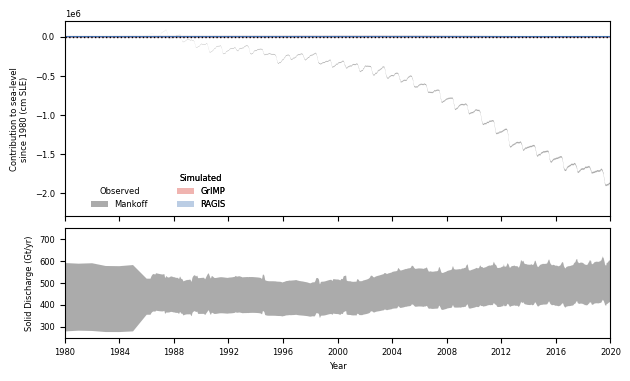

In [34]:
sigma_mass = 1 
sigma_discharge = 2


plot_experiments = experiments

plt.rc('font', size=6)
plt.style.use("tableau-colorblind10")

fig, axs = plt.subplots(nrows=2, ncols=1, sharex="col", figsize=(6.2, 3.6), height_ratios=[16, 9])
fig.subplots_adjust(wspace=0, hspace=0.075, bottom=0.1, top=0.98, left=0.1, right=0.98)


for obs, o, obs_color, obs_loc, obs_alpha  in zip([man], ["Mankoff"], 
                                       [man_color], [(0.1, 0.0)], [0.5]):
    obs_ci = axs[0].fill_between(obs["Date"], 
                    (obs[mass_varname] + sigma_mass * obs[mass_uncertainty_varname]), 
                    (obs[mass_varname] - sigma_mass * obs[mass_uncertainty_varname]), 
                    ls="solid", color=obs_color, lw=0, alpha=obs_alpha, label=o)
    axs[1].fill_between(obs["Date"], 
                    (obs[discharge_varname] + sigma_discharge * obs[discharge_uncertainty_varname]), 
                    (obs[discharge_varname] - sigma_discharge * obs[discharge_uncertainty_varname]), 
                    ls="solid", color=obs_color, lw=0, alpha=obs_alpha)


legend_obs = axs[0].legend(loc="lower center", bbox_to_anchor=obs_loc, title="Observed")
legend_obs.get_frame().set_linewidth(0.0)
legend_obs.get_frame().set_alpha(0.0)
axs[0].add_artist(legend_obs)


sims_cis = []
sims_lines = []
for k, exp in enumerate(plot_experiments):
    df = exp["data_df"]
    q_16 = df.groupby(by="time").quantile(0.16, numeric_only=True)
    q_50 = df.groupby(by="time").quantile(0.50, numeric_only=True)
    q_84 = df.groupby(by="time").quantile(0.84, numeric_only=True)
    sims_line = axs[0].plot(q_50.index, q_50[mass_varname], color=sim_colors[k], alpha=1.0, lw=1)
    axs[1].plot(q_50.index, q_50[discharge_varname], color=sim_colors[k], alpha=1.0, lw=1)
    sims_ci = axs[0].fill_between(q_16.index, q_16[mass_varname], 
                        q_84[mass_varname], color=sim_colors[k], alpha=0.2, lw=0, label=exp["Experiment"])
    axs[1].fill_between(q_16.index, q_16[discharge_varname], 
                        q_84[discharge_varname], color=sim_colors[k], alpha=0.2, lw=0)
    sims_cis.append(sims_ci)
    sims_lines.append(sims_line[0])

if len(sims_cis) < 4:
    ncols = 1
else:
    ncols = 2
legend_sims = axs[0].legend(handles=sims_cis, loc="lower center", bbox_to_anchor=[0.25, .0], 
                           title=f"Simulated", ncols=ncols)
legend_sims.get_frame().set_linewidth(0.0)
legend_sims.get_frame().set_alpha(0.0)
axs[0].add_artist(legend_sims)
    



fig.set_facecolor(bg_color)
for ax in axs:
    ax.set_facecolor(bg_color)
fig.set_facecolor(bg_color)

axs[0].axhline(0, color="k", ls="dotted", lw=1.0)
axs[0].set_xlabel("")
axs[0].set_ylabel("Contribution to sea-level\nsince 1980 (cm SLE)")
axs[-1].set_xlabel("Year")
axs[1].set_ylabel("Solid Discharge (Gt/yr)")
axs[0].set_xlim(pd.to_datetime("1980-1-1"), pd.to_datetime("2020-1-1"))
#axs[0].set_ylim(-1.75, 1.75)
axs[1].set_ylim(250, 750)

# fig.tight_layout()
fig.savefig(fig_dir / "ragis-comp_scalar_1980-2020.pdf")
fig.savefig(fig_dir / "ragis-comp_scalar_1980-2020.png", dpi=600)

In [22]:
man

,Rate of ice sheet mass change (Gt/yr),Rate of surface mass balance (Gt/yr),Rate of ice discharge (Gt/yr),Rate of ice sheet mass change uncertainty (Gt/yr),Rate of surface mass balance uncertainty (Gt/yr),Rate of ice discharge uncertainty (Gt/yr),Cumulative ice sheet mass change (Gt),Cumulative ice discharge anomaly (Gt),Cumulative surface mass balance anomaly (Gt),Cumulative ice sheet mass change uncertainty (Gt),Cumulative surface mass balance anomaly uncertainty (Gt),Cumulative ice discharge anomaly uncertainty (Gt),Date,Year,SLE (cm),SLE uncertainty (cm)
0,99.833454,515.317752,393.080706,136.344150,110.867988,78.117210,9.680486e+03,-5.921647e+04,-5.291525e+04,-1470.316960,-1161.150425,-887.650310,1840-01-01,1840.000000,0.027540,0.037612
1,111.620285,524.962345,392.006715,130.168490,103.732635,77.443510,9.792106e+03,-5.882446e+04,-5.239029e+04,-1418.157627,-1120.189001,-855.768448,1841-01-01,1841.000000,0.058332,0.052001
2,-101.661625,312.836025,392.006715,130.074685,102.580695,78.743640,9.690444e+03,-5.843246e+04,-5.207745e+04,-1377.634940,-1088.783675,-830.488709,1842-01-01,1842.000000,0.030287,0.063180
3,-115.031575,300.261775,392.006715,135.530340,110.019030,77.843550,9.575413e+03,-5.804045e+04,-5.177719e+04,-1340.538094,-1058.291587,-809.690696,1843-01-01,1843.000000,-0.001445,0.073413
4,-171.114516,245.534760,393.080706,135.046680,109.418262,77.826240,9.404298e+03,-5.764737e+04,-5.153166e+04,-1308.233454,-1031.911120,-791.363109,1844-01-01,1844.000000,-0.048649,0.082325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13955,-182.032435,327.027225,491.536010,83.463455,29.432505,77.936260,-2.154099e+06,6.437742e+06,4.603113e+06,10542.424384,9706.012415,4193.130177,2023-10-23,2023.808219,-596.877282,3.351472
13956,-276.014460,233.074400,491.565940,81.282580,20.976550,78.364405,-2.154376e+06,6.438234e+06,4.603346e+06,10542.696289,9706.032456,4193.725326,2023-10-24,2023.810959,-596.953424,3.351547
13957,-296.679300,212.455185,491.613025,81.239145,19.120890,78.792915,-2.154672e+06,6.438725e+06,4.603559e+06,10542.967897,9706.049107,4194.326931,2023-10-25,2023.813699,-597.035266,3.351622
13958,-189.311265,319.875780,491.665220,84.443115,28.788645,79.221425,-2.154861e+06,6.439217e+06,4.603879e+06,10543.261344,9706.086855,4194.935027,2023-10-26,2023.816438,-597.087490,3.351703


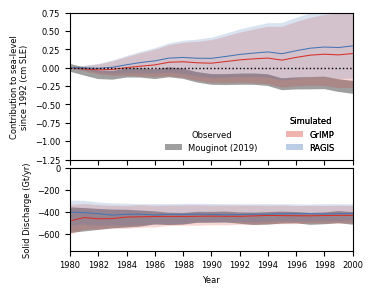

In [18]:
imbie[[discharge_uncertainty_varname]].mean() / mou_gis[[discharge_uncertainty_varname]].mean()
sigma_mass = 1
sigma_discharge = 5
plot_experiments = [experiments[0], experiments[1]]

plt.rc('font', size=6)
plt.style.use("tableau-colorblind10")

fig, axs = plt.subplots(nrows=2, ncols=1, sharex="col", figsize=(3.6, 2.8), height_ratios=[16, 9])
fig.subplots_adjust(wspace=0, hspace=0.075, bottom=0.125, top=0.975, left=0.175, right=0.96)


for obs, o, obs_color, obs_loc, obs_alpha  in zip([mou_gis], ["Mouginot (2019)"], 
                                       [mou_color], [(0.5, 0.0)], [0.5]):
    if mass_varname in obs:
        obs_ci = axs[0].fill_between(obs["Date"], 
                        (obs[mass_varname] + sigma_mass * obs[mass_uncertainty_varname]), 
                        (obs[mass_varname] - sigma_mass * obs[mass_uncertainty_varname]), 
                        ls="solid", color=obs_color, lw=0, alpha=obs_alpha, label=o)
    axs[1].fill_between(obs["Date"], 
                    (obs[discharge_varname] + sigma_discharge * obs[discharge_uncertainty_varname]), 
                    (obs[discharge_varname] - sigma_discharge * obs[discharge_uncertainty_varname]), 
                    ls="solid", color=obs_color, lw=0, alpha=obs_alpha)

    legend_obs = axs[0].legend(handles=[obs_ci], loc="lower center", bbox_to_anchor=obs_loc, 
                               title="Observed")
    legend_obs.get_frame().set_linewidth(0.0)
    legend_obs.get_frame().set_alpha(0.0)
    axs[0].add_artist(legend_obs)


sims_cis = []
sims_lines = []
for k, exp in enumerate(plot_experiments):
    df = exp["data_df"]
    q_05 = df.groupby(by="time").quantile(0.05, numeric_only=True)
    q_50 = df.groupby(by="time").quantile(0.50, numeric_only=True)
    q_95 = df.groupby(by="time").quantile(0.95, numeric_only=True)
    sims_line = axs[0].plot(q_50.index, q_50[mass_varname], color=sim_colors[k], alpha=1.0, lw=0.75)
    axs[1].plot(q_50.index, q_50[discharge_varname], color=sim_colors[k], alpha=1.0, lw=0.75)
    sims_ci = axs[0].fill_between(q_05.index, q_05[mass_varname], 
                        q_95[mass_varname], color=sim_colors[k], alpha=0.2, lw=0, label=exp["Experiment"])
    axs[1].fill_between(q_05.index, q_05[discharge_varname], 
                        q_95[discharge_varname], color=sim_colors[k], alpha=0.2, lw=0)
    sims_cis.append(sims_ci)
    sims_lines.append(sims_line[0])

if len(sims_cis) < 4:
    ncols = 1
else:
    ncols = 2
legend_sims = axs[0].legend(handles=sims_cis, loc="lower center", bbox_to_anchor=[0.85, .0], 
                           title=f"Simulated", ncols=ncols)
legend_sims.get_frame().set_linewidth(0.0)
legend_sims.get_frame().set_alpha(0.0)
axs[0].add_artist(legend_sims)
    

fig.set_facecolor(bg_color)
for ax in axs:
    ax.set_facecolor(bg_color)
fig.set_facecolor(bg_color)

axs[0].axhline(0, color="k", ls="dotted", lw=1.0)
axs[0].set_xlabel("")
axs[0].set_ylabel("Contribution to sea-level\nsince 1992 (cm SLE)")
axs[-1].set_xlabel("Year")
axs[1].set_ylabel("Solid Discharge (Gt/yr)")
axs[0].set_xlim(pd.to_datetime("1980-1-1"), pd.to_datetime("2020-1-1"))
axs[0].set_ylim(-1.25, 0.75)
axs[1].set_ylim(-750, 0)

axs[0].set_xlim(pd.to_datetime("1980-1-1"), pd.to_datetime("2000-1-1"))
fig.savefig(fig_dir / "ragis-comp_scalar_1980-2000.pdf")
fig.savefig(fig_dir / "ragis-comp_scalar_1980-2000.png", dpi=600)

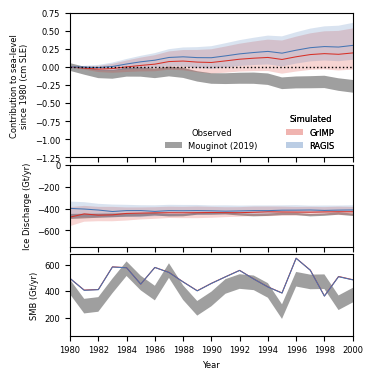

In [19]:
imbie[[discharge_uncertainty_varname]].mean() / mou_gis[[discharge_uncertainty_varname]].mean()
sigma_mass = 1
sigma_discharge = 1
sigma_smb = 1
plot_experiments = [experiments[0], experiments[1]]

plt.rc('font', size=6)
plt.style.use("tableau-colorblind10")

fig, axs = plt.subplots(nrows=3, ncols=1, sharex="col", figsize=(3.6, 3.8), height_ratios=[16, 9, 9])
fig.subplots_adjust(wspace=0, hspace=0.075, bottom=0.125, top=0.975, left=0.175, right=0.96)


for obs, o, obs_color, obs_loc, obs_alpha  in zip([mou_gis], ["Mouginot (2019)"], 
                                       [mou_color], [(0.5, 0.0)], [0.5]):
    if mass_varname in obs:
        obs_ci = axs[0].fill_between(obs["Date"], 
                        (obs[mass_varname] + sigma_mass * obs[mass_uncertainty_varname]), 
                        (obs[mass_varname] - sigma_mass * obs[mass_uncertainty_varname]), 
                        ls="solid", color=obs_color, lw=0, alpha=obs_alpha, label=o)
    axs[1].fill_between(obs["Date"], 
                    (obs[discharge_varname] + sigma_discharge * obs[discharge_uncertainty_varname]), 
                    (obs[discharge_varname] - sigma_discharge * obs[discharge_uncertainty_varname]), 
                    ls="solid", color=obs_color, lw=0, alpha=obs_alpha)
    axs[2].fill_between(obs["Date"], 
                    (obs[smb_varname] + sigma_smb * obs[smb_uncertainty_varname]), 
                    (obs[smb_varname] - sigma_smb * obs[smb_uncertainty_varname]), 
                    ls="solid", color=obs_color, lw=0, alpha=obs_alpha)

    legend_obs = axs[0].legend(handles=[obs_ci], loc="lower center", bbox_to_anchor=obs_loc, 
                               title="Observed")
    legend_obs.get_frame().set_linewidth(0.0)
    legend_obs.get_frame().set_alpha(0.0)
    axs[0].add_artist(legend_obs)


sims_cis = []
sims_lines = []
for k, exp in enumerate(plot_experiments):
    df = exp["data_df"]
    q_16 = df.groupby(by="time").quantile(0.16, numeric_only=True)
    q_50 = df.groupby(by="time").quantile(0.50, numeric_only=True)
    q_84 = df.groupby(by="time").quantile(0.84, numeric_only=True)
    sims_line = axs[0].plot(q_50.index, q_50[mass_varname], color=sim_colors[k], alpha=1.0, lw=0.75)
    axs[1].plot(q_50.index, q_50[discharge_varname], color=sim_colors[k], alpha=1.0, lw=0.75)
    axs[2].plot(q_50.index, q_50[smb_varname], color=sim_colors[k], alpha=1.0, lw=0.75)
    sims_ci = axs[0].fill_between(q_16.index, q_16[mass_varname], 
                        q_84[mass_varname], color=sim_colors[k], alpha=0.2, lw=0, label=exp["Experiment"])
    axs[1].fill_between(q_16.index, q_16[discharge_varname], 
                        q_84[discharge_varname], color=sim_colors[k], alpha=0.2, lw=0)
    axs[2].fill_between(q_16.index, q_16[smb_varname], 
                        q_84[smb_varname], color=sim_colors[k], alpha=0.2, lw=0)
    sims_cis.append(sims_ci)
    sims_lines.append(sims_line[0])

if len(sims_cis) < 4:
    ncols = 1
else:
    ncols = 2
legend_sims = axs[0].legend(handles=sims_cis, loc="lower center", bbox_to_anchor=[0.85, .0], 
                           title=f"Simulated", ncols=ncols)
legend_sims.get_frame().set_linewidth(0.0)
legend_sims.get_frame().set_alpha(0.0)
axs[0].add_artist(legend_sims)
    

fig.set_facecolor(bg_color)
for ax in axs:
    ax.set_facecolor(bg_color)
fig.set_facecolor(bg_color)

axs[0].axhline(0, color="k", ls="dotted", lw=1.0)
axs[0].set_xlabel("")
axs[0].set_ylabel("Contribution to sea-level\nsince 1980 (cm SLE)")
axs[-1].set_xlabel("Year")
axs[1].set_ylabel("Ice Discharge (Gt/yr)")
axs[2].set_ylabel("SMB (Gt/yr)")
axs[0].set_ylim(-1.25, 0.75)
axs[1].set_ylim(-750, 0)
axs[0].set_xlim(pd.to_datetime("1980-1-1"), pd.to_datetime("2000-1-1"))
fig.savefig(fig_dir / "ragis-comp-3_scalar_1980-2000.pdf")
fig.savefig(fig_dir / "ragis-comp-3_scalar_1980-2000.png", dpi=600)

## Plot sensitivity index

In [20]:
plt.rc('font', size=6)
plt.style.use("tableau-colorblind10")


for e in experiments:
    sa_df = e["sensitivity_df"]
    si = "S1"
    outfile = f"""{e["DEM"]}_{e["lhs"]}.pdf"""
    fig, axs = plt.subplots(
        2,
        1,
        sharex="col",
        figsize=[6.2, 3.8],
    )
    fig.subplots_adjust(bottom=0.0)
    for k, m_var in enumerate(["limnsw (kg)", "grounding_line_flux (Gt year-1)"]):
        m_df = sa_df[sa_df["Variable"] == m_var]
        ax = axs.ravel()[k]
        p_df = m_df[m_df["Si"] == si].drop(columns=["Si", "Variable"]).set_index("Date")
        p_conf_df = m_df[m_df["Si"] == si + "_conf"].drop(columns=["Si"])

        [
            ax.plot(p_df.index, p_df[v], lw=1, label=v)
            for v in sa_df.drop(columns=["Si", "Variable", "Date"]).keys()
        ]

        [
            ax.fill_between(
                p_df.index,
                p_df[v].values - p_conf_df[v].values,
                p_df[v].values + p_conf_df[v].values,
                alpha=0.2,
                lw=0,
            )
            for v in sa_df.drop(columns=["Si", "Variable", "Date"]).keys()
        ]
        ax.set_xlim(datetime(1980, 1, 1), datetime(2020, 1, 1))
        lgd = ax.set_title(f"{si} indices for '{m_var}'")
    legend = axs[-1].legend(loc="lower left", ncols=3, bbox_to_anchor=(0, -0.75))
    fig.tight_layout()
    o_file = fig_dir / f"{si}_{outfile}"
    fig.savefig(o_file)
    !open o_file

KeyError: 'sensitivity_df'

In [ ]:
m_e = experiments[0]["data_df"]
ragis_calib, weights = resample_ensemble_by_data(imbie, m_e, 
                                        fudge_factor=3, verbose=True)
calib_exps = ragis_calib["id"].unique()
print(calib_exps)

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=1, sharex="col", figsize=(12, 8))
fig.subplots_adjust(wspace=0.0, hspace=0.0)

q_5 = ragis_calib.groupby(by="Year").quantile(0.05, numeric_only=True)
q_16 = ragis_calib.groupby(by="Year").quantile(0.16, numeric_only=True)
q_50 = ragis_calib.groupby(by="Year").quantile(0.50, numeric_only=True)
q_84 = ragis_calib.groupby(by="Year").quantile(0.84, numeric_only=True)
q_95 = ragis_calib.groupby(by="Year").quantile(0.95, numeric_only=True)
for exp in m_e:
    print(exp)
    e = m_e[m_e["id"] == exp]
    axs[0].plot(e["Year"], e[mass_varname], color="k", lw=1)
    print(e)
    axs[1].plot(e["Year"], e[discharge_varname], color="k", lw=1)

for exp in calib_exps:
    e = m_e[m_e["id"] == exp]
    axs[0].plot(e["Year"], e[mass_varname], lw=1)
    axs[1].plot(e["Year"], e[discharge_varname], lw=1)

axs[0].fill_between(q_50.index, q_16[mass_varname], q_84[mass_varname], color="w")
axs[0].fill_between(imbie["Year"], 
                    (imbie[mass_varname] + sigma * imbie[mass_uncertainty_varname]), 
                    (imbie[mass_varname] - sigma * imbie[mass_uncertainty_varname]), 
                    ls="solid", lw=0, alpha=0.35, label="2-$\sigma$ IMBIE")
axs[1].fill_between(imbie["Year"], 
                    (imbie[discharge_varname] + sigma * imbie[discharge_uncertainty_varname]), 
                    (imbie[discharge_varname] - sigma * imbie[discharge_uncertainty_varname]), 
                    ls="solid", lw=0, alpha=0.35, color=imbie_color)


axs[0].set_xlim(1992, 2020)
axs[0].set_ylim(0, 2)
fig.set_facecolor(bg_color)
for ax in axs:
    ax.set_facecolor(bg_color)
fig.set_facecolor(bg_color)




In [ ]:
d_dir = Path("/Users/andy/Google Drive/My Drive/Projects/RAGIS/data")

In [ ]:
df = pd.read_csv(d_dir / "MB_SMB_D_BMB.csv")

In [ ]:
df["time"]

In [ ]:
def load_mankoff(
    url: Union[str, Path] = Path(
        "/Users/andy/Google Drive/My Drive/Projects/RAGIS/data/MB_SMB_D_BMB.csv"
    ),
):
    df = pd.read_csv(url, parse_dates=["time"], infer_datetime_format=True)
    d_df.name = "Rate of ice discharge (Gt/yr)"
    de_df = de_df.drop(columns="Date").apply(np.square).sum(axis=1).apply(np.sqrt)
    de_df.name = "Rate of ice discharge uncertainty (Gt/yr)"
    df = pd.merge(d_df, de_df, left_index=True, right_index=True)
    df["Date"] = m_df["Date"]
    df["Year"] = [to_decimal_year(d) for d in df["Date"]]
    return df


In [ ]:
from typing import Union

In [ ]:
man[man["Year"] == 1980]

In [ ]:

url: Union[str, Path] = Path(
    "/Users/andy/Google Drive/My Drive/Projects/RAGIS/data/MB_SMB_D_BMB.csv"
)
norm_year: float = 1980.0,
    
df = pd.read_csv(url, parse_dates=["time"], infer_datetime_format=True)

df = df.rename(columns={"time": "Date",
                        "MB": "Rate of ice sheet mass change (Gt/yr)",
                        "SMB": "Rate of surface mass balance (Gt/yr)",
                        "D":"Rate of ice discharge (Gt/yr)",
                        "MB_err": "Rate of ice sheet mass change uncertainty (Gt/yr)",
                        "SMB_err": "Rate of surface mass balance uncertainty (Gt/yr)",
                        "D_err":"Rate of ice discharge uncertainty (Gt/yr)",
})
days_of_year = np.where(df['Date'].dt.is_leap_year, 366, 365)
df["Year"] = [to_decimal_year(d) for d in df["Date"]]
time = df[["Date", "Year"]]
df = df[["Rate of ice sheet mass change (Gt/yr)",
"Rate of surface mass balance (Gt/yr)",
"Rate of ice discharge (Gt/yr)",
"Rate of ice sheet mass change uncertainty (Gt/yr)",
"Rate of surface mass balance uncertainty (Gt/yr)",
"Rate of ice discharge uncertainty (Gt/yr)"]].multiply(days_of_year, axis=0)
df["Cumulative ice sheet mass change (Gt)"] = df["Rate of ice sheet mass change (Gt/yr)"].cumsum()
df["Cumulative ice discharge anomaly (Gt)"] = df["Rate of ice discharge (Gt/yr)"].cumsum()
df["Cumulative surface mass balance anomlay (Gt)"] = df["Rate of surface mass balance (Gt/yr)"].cumsum()
df["Cumulative ice sheet mass balance uncertainty (Gt)"] = df["Rate of ice sheet mass change uncertainty (Gt/yr)"].apply(np.square).cumsum().apply(np.sqrt)
df["Cumulative surface mass balance anomaly uncertainty (Gt)"] = df["Rate of surface mass balance uncertainty (Gt/yr)"].apply(np.square).cumsum().apply(np.sqrt)
df["Cumulative ice discharge anomaly uncertainty (Gt)"] = df["Rate of ice discharge uncertainty (Gt/yr)"].apply(np.square).cumsum().apply(np.sqrt)
df = pd.merge(df, time, left_index=True, right_index=True)          
# Normalize
for v in [
    "Cumulative ice sheet mass change (Gt)",
    ]:
    df[v] -= df[df["Year"] == norm_year][v].values
    


In [ ]:
df

In [ ]:
def root_sum_square(S):
    return S.apply(np.square).cumsum().apply(np.sqrt)

In [ ]:
df["Rate of ice sheet mass change uncertainty (Gt/yr)"].apply(root_sum_square)

In [ ]:
pd.Timestamp(d.year.values, 12, 31)

In [ ]:
days_of_year = np.where(df['Date'].dt.is_leap_year, 366, 365)

<Axes: >

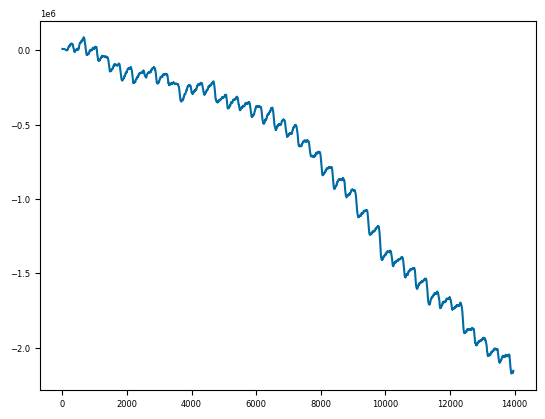

In [36]:
man["Cumulative ice sheet mass change (Gt)"].plot()

In [54]:
man["Rate of ice sheet mass change (Gt/yr)"].cumsum()

0        9.983345e+01
1        2.114537e+02
2        1.097921e+02
3       -5.239461e+00
4       -1.763540e+02
             ...     
13955   -2.163680e+06
13956   -2.163956e+06
13957   -2.164253e+06
13958   -2.164442e+06
13959   -2.164934e+06
Name: Rate of ice sheet mass change (Gt/yr), Length: 13960, dtype: float64

In [50]:
df = man["Rate of ice sheet mass change (Gt/yr)"].divide(days_of_year).cumsum().multiply(days_of_year)

In [44]:
    days_of_year = np.where(man["Date"].dt.is_leap_year, 366, 365)


In [52]:
df[df["Year"] == norm_year].values

KeyError: 'Year'

In [122]:
4000/30

133.33333333333334

In [124]:
    url: Union[str, Path] = Path(
        "/Users/andy/Google Drive/My Drive/Projects/RAGIS/data/MB_SMB_D_BMB.csv"
    )
    norm_year: Union[None, float] = None
    df = pd.read_csv(url, parse_dates=["time"], infer_datetime_format=True)

    df = df.rename(
        columns={
            "time": "Date",
            "MB": "Rate of ice sheet mass change (Gt/yr)",
            "SMB": "Rate of surface mass balance (Gt/yr)",
            "D": "Rate of ice discharge (Gt/yr)",
            "MB_err": "Rate of ice sheet mass change uncertainty (Gt/yr)",
            "SMB_err": "Rate of surface mass balance uncertainty (Gt/yr)",
            "D_err": "Rate of ice discharge uncertainty (Gt/yr)",
        }
    )
    days_of_year = np.where(df["Date"].dt.is_leap_year, 366, 365)


<Axes: >

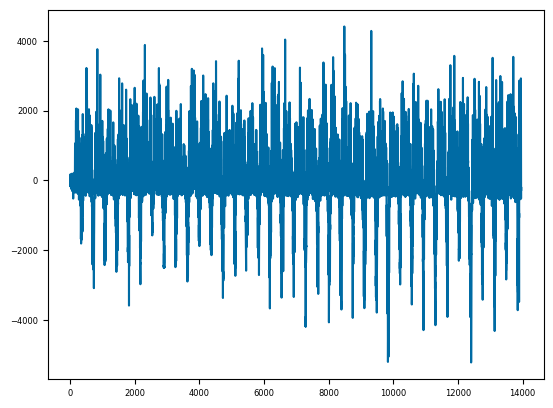

In [130]:
df["Rate of ice sheet mass change (Gt/yr)"].multiply(365).plot()

In [132]:
man.mean()

/var/folders/pb/9bmdq04j7h9126gzz9zd3b_80000gn/T/ipykernel_33694/3283255009.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  man.mean()


Rate of ice sheet mass change (Gt/yr)                      -1.550812e+02
Rate of surface mass balance (Gt/yr)                        3.336181e+02
Rate of ice discharge (Gt/yr)                               4.655672e+02
Rate of ice sheet mass change uncertainty (Gt/yr)           8.788302e+01
Rate of surface mass balance uncertainty (Gt/yr)            3.078033e+01
Rate of ice discharge uncertainty (Gt/yr)                   4.336391e+01
Cumulative ice sheet mass change (Gt)                      -7.960472e+05
Cumulative ice discharge anomaly (Gt)                       3.088133e+06
Cumulative surface mass balance anomaly (Gt)                2.445448e+06
Cumulative ice sheet mass change uncertainty (Gt)           6.210462e+03
Cumulative surface mass balance anomaly uncertainty (Gt)    5.761413e+03
Cumulative ice discharge anomaly uncertainty (Gt)           2.408715e+03
Year                                                        2.003943e+03
SLE (cm)                                           

In [135]:
    df = pd.read_csv(url, parse_dates=["time"], infer_datetime_format=True)


In [136]:
df

,time,MB,MB_err,SMB,SMB_err,D,D_err,BMB,BMB_err
0,1840-01-01,0.272769,0.372525,1.407972,0.302918,1.073991,0.213435,0.061212,0.038220
1,1841-01-01,0.305809,0.356626,1.438253,0.284199,1.073991,0.212174,0.058454,0.037356
2,1842-01-01,-0.278525,0.356369,0.857085,0.281043,1.073991,0.215736,0.061620,0.038363
3,1843-01-01,-0.315155,0.371316,0.822635,0.301422,1.073991,0.213270,0.063799,0.039190
4,1844-01-01,-0.467526,0.368980,0.670860,0.298957,1.073991,0.212640,0.064395,0.039434
...,...,...,...,...,...,...,...,...,...
13955,2023-10-23,-0.498719,0.228667,0.895965,0.080637,1.346674,0.213524,0.048010,0.013927
13956,2023-10-24,-0.756204,0.222692,0.638560,0.057470,1.346756,0.214697,0.048007,0.013927
13957,2023-10-25,-0.812820,0.222573,0.582069,0.052386,1.346885,0.215871,0.048004,0.013927
13958,2023-10-26,-0.518661,0.231351,0.876372,0.078873,1.347028,0.217045,0.048004,0.013927


In [150]:

url: Union[str, Path] = Path("/Users/andy/Google Drive/My Drive/Projects/RAGIS/data/MB_SMB_D_BMB.csv")
df = pd.read_csv(url, parse_dates=["time"], infer_datetime_format=True)
ﬁfig = plt.figure()
ax = fig.add_subplot(111)
sns.lineplot(data=df, x="time", y="MB", ax=ax)


<Axes: xlabel='time', ylabel='MB'>

<Figure size 640x480 with 0 Axes>

In [143]:
url = Path("/Users/andy/Google Drive/My Drive/Projects/RAGIS/data/MB_region.nc")
ds = xr.open_dataset(url)

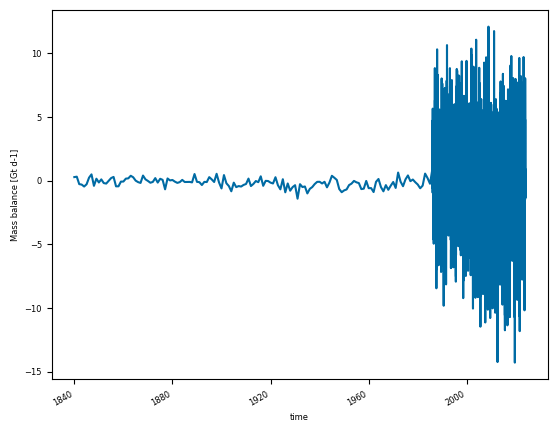

In [145]:
ds["MB"].plot.line()

In [148]:
ds["MB"]

<xarray.DataArray 'MB' (time: 13960)>
array([ 0.272769,  0.305809, -0.278525, ..., -0.81282 , -0.518661, -1.347223],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1840-01-01 1841-01-01 ... 2023-10-27
Attributes:
    long_name:      Mass balance
    standard_name:  land_ice_mass_tranport
    units:          Gt d-1

In [151]:
df['MB'].resample('YS').mean().plot(drawstyle='steps')

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'RangeIndex'

<Axes: xlabel='time'>

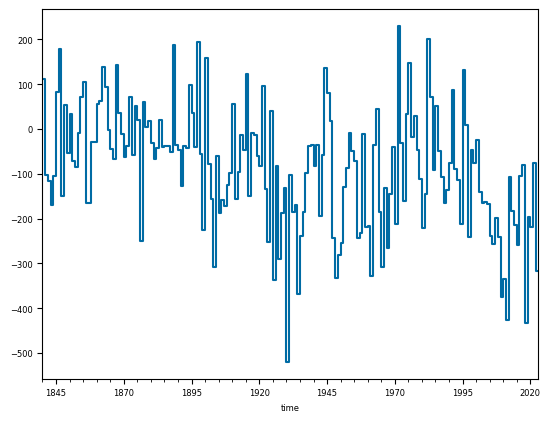

In [158]:
dff = df.set_index("time")["MB"].resample('YS').mean().multiply(365)
dff.plot(drawstyle='steps')

/var/folders/pb/9bmdq04j7h9126gzz9zd3b_80000gn/T/ipykernel_33694/1381472261.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annual["start_date"] = pd.date_range("1840-01-01", "1985-01-01", freq="1AS")
/var/folders/pb/9bmdq04j7h9126gzz9zd3b_80000gn/T/ipykernel_33694/1381472261.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annual["end_date"] = pd.date_range("1841-01-01", "1986-01-01", freq="1AS")
/var/folders/pb/9bmdq04j7h9126gzz9zd3b_80000gn/T/ipykernel_33694/1381472261.py:4: SettingWithCopyWarning

In [210]:
df

,Rate of ice sheet mass change (Gt/yr),Rate of surface mass balance (Gt/yr),Rate of ice discharge (Gt/yr),Rate of ice sheet mass change uncertainty (Gt/yr),Rate of surface mass balance uncertainty (Gt/yr),Rate of ice discharge uncertainty (Gt/yr),Cumulative ice sheet mass change (Gt),Cumulative ice discharge anomaly (Gt),Cumulative surface mass balance anomaly (Gt),Cumulative ice sheet mass change uncertainty (Gt),Cumulative surface mass balance anomaly uncertainty (Gt),Cumulative ice discharge anomaly uncertainty (Gt),Date,Year,SLE (cm),SLE uncertainty (cm),start_date,end_date,delta
0,99.833454,515.317752,393.080706,136.344150,110.867988,78.117210,9.680486e+03,-5.921647e+04,-5.291525e+04,-1470.316960,-1161.150425,-887.650310,1840-01-01,1840.000000,0.027540,0.037612,1840-01-01,1841-01-01,366 days
1,111.620285,524.962345,392.006715,130.168490,103.732635,77.443510,9.792106e+03,-5.882446e+04,-5.239029e+04,-1418.157627,-1120.189001,-855.768448,1841-01-01,1841.000000,0.058332,0.052001,1841-01-01,1842-01-01,365 days
2,-101.661625,312.836025,392.006715,130.074685,102.580695,78.743640,9.690444e+03,-5.843246e+04,-5.207745e+04,-1377.634940,-1088.783675,-830.488709,1842-01-01,1842.000000,0.030287,0.063180,1842-01-01,1843-01-01,365 days
3,-115.031575,300.261775,392.006715,135.530340,110.019030,77.843550,9.575413e+03,-5.804045e+04,-5.177719e+04,-1340.538094,-1058.291587,-809.690696,1843-01-01,1843.000000,-0.001445,0.073413,1843-01-01,1844-01-01,365 days
4,-171.114516,245.534760,393.080706,135.046680,109.418262,77.826240,9.404298e+03,-5.764737e+04,-5.153166e+04,-1308.233454,-1031.911120,-791.363109,1844-01-01,1844.000000,-0.048649,0.082325,1844-01-01,1845-01-01,366 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13955,-182.032435,327.027225,491.536010,83.463455,29.432505,77.936260,-2.154099e+06,6.437742e+06,4.603113e+06,10542.424384,9706.012415,4193.130177,2023-10-23,2023.808219,-596.877282,3.351472,2023-10-23,2023-10-24,1 days
13956,-276.014460,233.074400,491.565940,81.282580,20.976550,78.364405,-2.154376e+06,6.438234e+06,4.603346e+06,10542.696289,9706.032456,4193.725326,2023-10-24,2023.810959,-596.953424,3.351547,2023-10-24,2023-10-25,1 days
13957,-296.679300,212.455185,491.613025,81.239145,19.120890,78.792915,-2.154672e+06,6.438725e+06,4.603559e+06,10542.967897,9706.049107,4194.326931,2023-10-25,2023.813699,-597.035266,3.351622,2023-10-25,2023-10-26,1 days
13958,-189.311265,319.875780,491.665220,84.443115,28.788645,79.221425,-2.154861e+06,6.439217e+06,4.603879e+06,10543.261344,9706.086855,4194.935027,2023-10-26,2023.816438,-597.087490,3.351703,2023-10-26,2023-10-27,1 days


In [192]:
pd.date_range?

0     366 days
1     365 days
2     365 days
3     365 days
4     366 days
        ...   
141   365 days
142   365 days
143   365 days
144   366 days
145   365 days
Length: 146, dtype: timedelta64[ns]

<Axes: xlabel='Date', ylabel='Rate of ice sheet mass change (Gt/day)'>

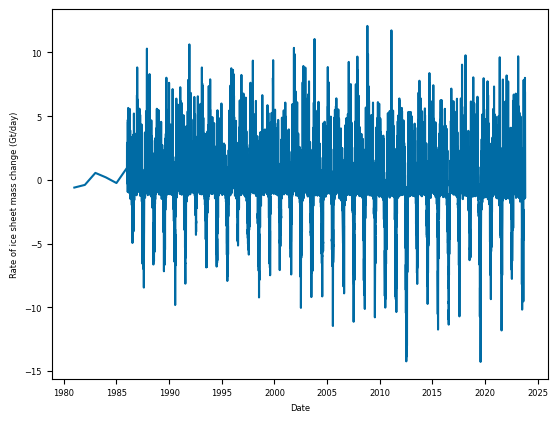

In [364]:
sns.lineplot(df[df["Date"] > "1980-01-01"], x="Date", y="Rate of ice sheet mass change (Gt/day)")

<Axes: >

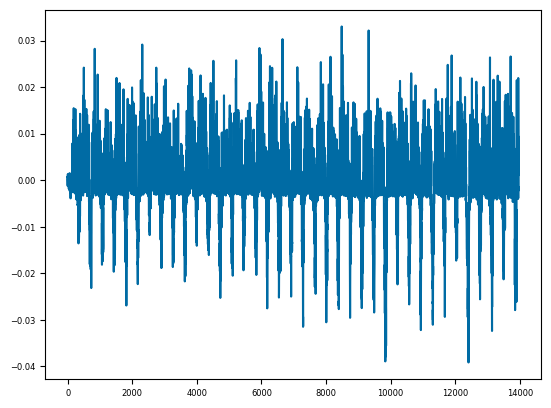

In [359]:
df["Rate of ice sheet mass change (Gt/yr)"].plot()

In [370]:
k =df[(df["Date"] > "1982-01-01") & (df["Date"] < "1988-01-01")]

<Axes: >

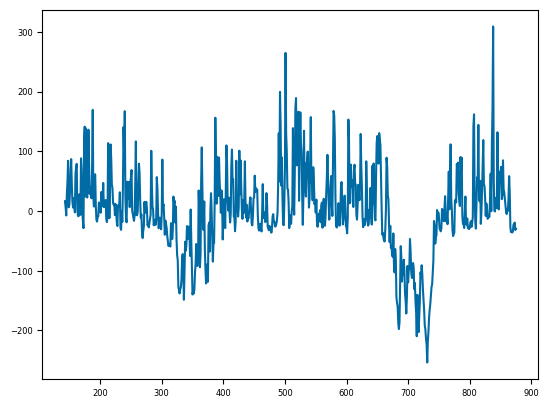

In [374]:
k["Rate of ice sheet mass change (Gt/day)"].multiply(30).plot()

In [378]:
df["delta"]

0        366
1        365
2        365
3        365
4        366
        ... 
13955    365
13956    365
13957    365
13958    365
13959    365
Name: delta, Length: 13960, dtype: int64

In [325]:
sns.lineplot(df[df["Date"] >= "1986-01-01"], x="Date", y="Cumulative ice sheet mass change (Gt)")

ValueError: Could not interpret value `Cumulative ice sheet mass change (Gt)` for parameter `y`

<Axes: >

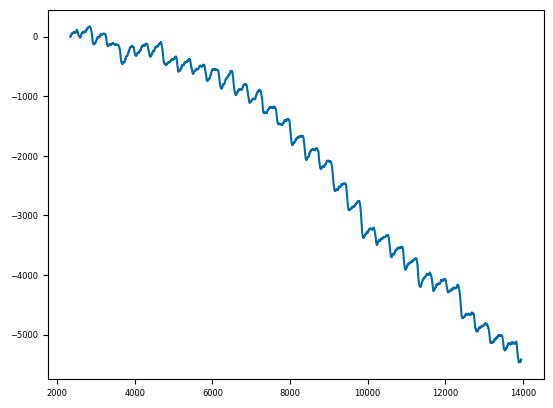

In [321]:
df[df["time"] >= "1992-01-01"]["MB"].cumsum().plot()

In [328]:
    df = pd.read_csv(url, parse_dates=["time"], infer_datetime_format=True)
    
    df = df.rename(
        columns={
            "time": "Date",
            "MB": "Rate of ice sheet mass change (Gt/day)",
            "SMB": "Rate of surface mass balance (Gt/day)",
            "D": "Rate of ice discharge (Gt/day)",
            "MB_err": "Rate of ice sheet mass change uncertainty (Gt/day)",
            "SMB_err": "Rate of surface mass balance uncertainty (Gt/day)",
            "D_err": "Rate of ice discharge uncertainty (Gt/day)",
        }
    )
    days_of_year = np.where(df["Date"].dt.is_leap_year, 366, 365)


In [430]:
df["Rate of ice sheet mass change (Gt/day)"].cumsum().plot()

KeyError: 'Rate of ice sheet mass change (Gt/day)'

In [431]:
df

,Date,Rate of ice sheet mass change (Gt/yr),Rate of ice sheet mass change uncertainty (Gt/yr),Rate of surface mass balance (Gt/yr),Rate of surface mass balance uncertainty (Gt/yr),Rate of ice discharge (Gt/yr),Rate of ice discharge uncertainty (Gt/yr),BMB,BMB_err,Year
0,1840-01-05,0.272769,0.372525,1.407972,0.302918,1.073991,0.213435,0.061212,0.038220,1840.010929
1,1840-01-12,0.272769,0.372525,1.407972,0.302918,1.073991,0.213435,0.061212,0.038220,1840.030055
2,1840-01-19,0.272769,0.372525,1.407972,0.302918,1.073991,0.213435,0.061212,0.038220,1840.049180
3,1840-01-26,0.272769,0.372525,1.407972,0.302918,1.073991,0.213435,0.061212,0.038220,1840.068306
4,1840-02-02,0.272769,0.372525,1.407972,0.302918,1.073991,0.213435,0.061212,0.038220,1840.087432
...,...,...,...,...,...,...,...,...,...,...
9587,2023-10-01,-0.580831,0.206426,0.807988,0.072719,1.340765,0.184183,0.048054,0.013927,2023.747945
9588,2023-10-08,0.743462,0.317146,2.136685,0.192302,1.343620,0.192399,0.049603,0.014036,2023.767123
9589,2023-10-15,1.251113,0.320011,2.645735,0.238116,1.345550,0.200614,0.049071,0.013990,2023.786301
9590,2023-10-22,3.928081,0.538924,5.322655,0.479039,1.346364,0.208829,0.048210,0.013929,2023.805479


In [396]:
    df = pd.read_csv(url, parse_dates=["time"], infer_datetime_format=True)
    
    df = df.rename(
        columns={
            "time": "Date",
            "MB": "Rate of ice sheet mass change (Gt/yr)",
            "SMB": "Rate of surface mass balance (Gt/yr)",
            "D": "Rate of ice discharge (Gt/yr)",
            "MB_err": "Rate of ice sheet mass change uncertainty (Gt/yr)",
            "SMB_err": "Rate of surface mass balance uncertainty (Gt/yr)",
            "D_err": "Rate of ice discharge uncertainty (Gt/yr)",
        }
    )

    days_of_year = np.where(df["Date"].dt.is_leap_year, 366, 365)
    df["Year"] = [to_decimal_year(d) for d in df["Date"]]
    
    time = df[["Date", "Year"]]
    time["delta"] = 1
    time["delta"][df["Date"] < "1986-01-01"] = days_of_year[df["Date"] < "1986-01-01"]
    df = df[
        [
            "Rate of ice sheet mass change (Gt/yr)",
            "Rate of surface mass balance (Gt/yr)",
            "Rate of ice discharge (Gt/yr)",
            "Rate of ice sheet mass change uncertainty (Gt/yr)",
            "Rate of surface mass balance uncertainty (Gt/yr)",
            "Rate of ice discharge uncertainty (Gt/yr)",
        ]
    ].multiply(days_of_year, axis=0)
    df["Cumulative ice sheet mass change (Gt)"] = df[
        "Rate of ice sheet mass change (Gt/yr)"
    ].cumsum()
    df["Cumulative ice discharge anomaly (Gt)"] = df[
        "Rate of ice discharge (Gt/yr)"
    ].cumsum()
    df["Cumulative surface mass balance anomaly (Gt)"] = df[
        "Rate of surface mass balance (Gt/yr)"
    ].cumsum()
    df["Cumulative ice sheet mass change uncertainty (Gt)"] = (
        df["Rate of ice sheet mass change uncertainty (Gt/yr)"]
        .apply(np.square)
        .cumsum()
        .apply(np.sqrt)
    )
    df["Cumulative surface mass balance anomaly uncertainty (Gt)"] = (
        df["Rate of surface mass balance uncertainty (Gt/yr)"]
        .apply(np.square)
        .cumsum()
        .apply(np.sqrt)
    )
    df["Cumulative ice discharge anomaly uncertainty (Gt)"] = (
        df["Rate of ice discharge uncertainty (Gt/yr)"]
        .apply(np.square)
        .cumsum()
        .apply(np.sqrt)
    )
    df = pd.merge(df, time, left_index=True, right_index=True)


/var/folders/pb/9bmdq04j7h9126gzz9zd3b_80000gn/T/ipykernel_33694/1281568392.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time["delta"] = 1
/var/folders/pb/9bmdq04j7h9126gzz9zd3b_80000gn/T/ipykernel_33694/1281568392.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time["delta"][df["Date"] < "1986-01-01"] = days_of_year[df["Date"] < "1986-01-01"]


In [387]:
len(days_of_year)

13960

In [437]:
    df = pd.read_csv(url, parse_dates=["time"], infer_datetime_format=True)

    df = df.rename(
        columns={
            "time": "Date",
            "MB": "Rate of ice sheet mass change (Gt/yr)",
            "SMB": "Rate of surface mass balance (Gt/yr)",
            "D": "Rate of ice discharge (Gt/yr)",
            "MB_err": "Rate of ice sheet mass change uncertainty (Gt/yr)",
            "SMB_err": "Rate of surface mass balance uncertainty (Gt/yr)",
            "D_err": "Rate of ice discharge uncertainty (Gt/yr)",
        }
    )

    days_of_year = np.where(df["Date"].dt.is_leap_year, 366, 365)
    time = df[["Date"]]
    df = df[
        [
            "Rate of ice sheet mass change (Gt/yr)",
            "Rate of surface mass balance (Gt/yr)",
            "Rate of ice discharge (Gt/yr)",
            "Rate of ice sheet mass change uncertainty (Gt/yr)",
            "Rate of surface mass balance uncertainty (Gt/yr)",
            "Rate of ice discharge uncertainty (Gt/yr)",
        ]
    ].multiply(days_of_year, axis=0)
    df = (
        df.set_index(time["Date"])
        .resample("1D")
        .mean()
        .ffill()
        .resample("W")
        .mean()
        .reset_index(drop=True)
    )
    df["Cumulative ice sheet mass change (Gt)"] = df[
        "Rate of ice sheet mass change (Gt/yr)"
    ].cumsum()
    df["Cumulative ice discharge anomaly (Gt)"] = df[
        "Rate of ice discharge (Gt/yr)"
    ].cumsum()
    df["Cumulative surface mass balance anomaly (Gt)"] = df[
        "Rate of surface mass balance (Gt/yr)"
    ].cumsum()
    df["Cumulative ice sheet mass change uncertainty (Gt)"] = (
        df["Rate of ice sheet mass change uncertainty (Gt/yr)"]
        .apply(np.square)
        .cumsum()
        .apply(np.sqrt)
    )
    df["Cumulative surface mass balance anomaly uncertainty (Gt)"] = (
        df["Rate of surface mass balance uncertainty (Gt/yr)"]
        .apply(np.square)
        .cumsum()
        .apply(np.sqrt)
    )
    df["Cumulative ice discharge anomaly uncertainty (Gt)"] = (
        df["Rate of ice discharge uncertainty (Gt/yr)"]
        .apply(np.square)
        .cumsum()
        .apply(np.sqrt)
    )
    df = pd.merge(df, time, left_index=True, right_index=True)
    df["Year"] = [to_decimal_year(d) for d in df["Date"]]

    cmSLE = 1.0 / 362.5 / 10.0
    df["SLE (cm)"] = df["Cumulative ice sheet mass change (Gt)"] * cmSLE
    df["SLE uncertainty (cm)"] = (
        df["Cumulative ice sheet mass change uncertainty (Gt)"] * cmSLE
    )


In [388]:
pdf = df[
        [
            "Rate of ice sheet mass change (Gt/yr)",
            "Rate of surface mass balance (Gt/yr)",
            "Rate of ice discharge (Gt/yr)",
            "Rate of ice sheet mass change uncertainty (Gt/yr)",
            "Rate of surface mass balance uncertainty (Gt/yr)",
            "Rate of ice discharge uncertainty (Gt/yr)",
        ]
    ]

In [391]:
pdf.multiply(days_of_year)

ValueError: Unable to coerce to Series, length must be 6: given 13960

<Axes: >

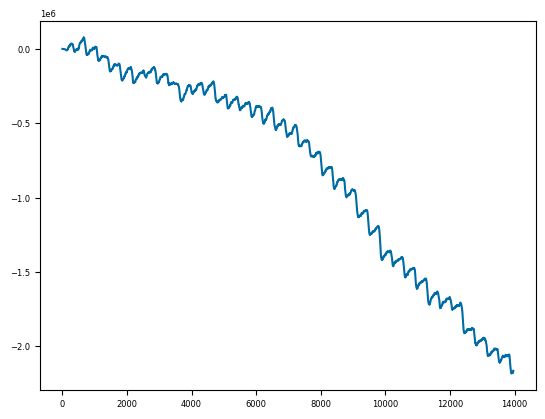

In [399]:
df["Cumulative ice sheet mass change (Gt)"].plot()

In [442]:
    df = pd.read_csv(url, parse_dates=["time"], infer_datetime_format=True)

    df = df.rename(
        columns={
            "time": "Date",
            "MB": "Rate of ice sheet mass change (Gt/yr)",
            "SMB": "Rate of surface mass balance (Gt/yr)",
            "D": "Rate of ice discharge (Gt/yr)",
            "MB_err": "Rate of ice sheet mass change uncertainty (Gt/yr)",
            "SMB_err": "Rate of surface mass balance uncertainty (Gt/yr)",
            "D_err": "Rate of ice discharge uncertainty (Gt/yr)",
        }
    )

    days_of_year = np.where(df["Date"].dt.is_leap_year, 366, 365)
    time = df[["Date"]]
    df = df[
        [
            "Rate of ice sheet mass change (Gt/yr)",
            "Rate of surface mass balance (Gt/yr)",
            "Rate of ice discharge (Gt/yr)",
            "Rate of ice sheet mass change uncertainty (Gt/yr)",
            "Rate of surface mass balance uncertainty (Gt/yr)",
            "Rate of ice discharge uncertainty (Gt/yr)",
        ]
    ]


<Axes: >

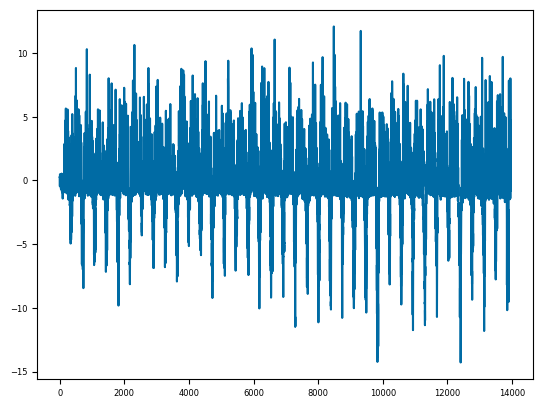

In [443]:
df["Rate of ice sheet mass change (Gt/yr)"].plot()

ValueError: could not convert string to float: '.'

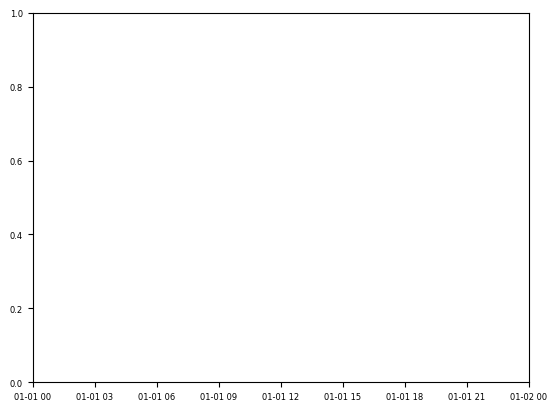

In [450]:

df = pd.merge(df, time, left_index=True, right_index=True)
sns.lineplot(df, x="Date", y="Rate of ice sheet mass change (Gt/yr)", ms=".")

In [451]:
df

,Rate of ice sheet mass change (Gt/yr),Rate of surface mass balance (Gt/yr),Rate of ice discharge (Gt/yr),Rate of ice sheet mass change uncertainty (Gt/yr),Rate of surface mass balance uncertainty (Gt/yr),Rate of ice discharge uncertainty (Gt/yr),Date_x,Date_y,Date
0,0.272769,1.407972,1.073991,0.372525,0.302918,0.213435,1840-01-01,1840-01-01,1840-01-01
1,0.305809,1.438253,1.073991,0.356626,0.284199,0.212174,1841-01-01,1841-01-01,1841-01-01
2,-0.278525,0.857085,1.073991,0.356369,0.281043,0.215736,1842-01-01,1842-01-01,1842-01-01
3,-0.315155,0.822635,1.073991,0.371316,0.301422,0.213270,1843-01-01,1843-01-01,1843-01-01
4,-0.467526,0.670860,1.073991,0.368980,0.298957,0.212640,1844-01-01,1844-01-01,1844-01-01
...,...,...,...,...,...,...,...,...,...
13955,-0.498719,0.895965,1.346674,0.228667,0.080637,0.213524,2023-10-23,2023-10-23,2023-10-23
13956,-0.756204,0.638560,1.346756,0.222692,0.057470,0.214697,2023-10-24,2023-10-24,2023-10-24
13957,-0.812820,0.582069,1.346885,0.222573,0.052386,0.215871,2023-10-25,2023-10-25,2023-10-25
13958,-0.518661,0.876372,1.347028,0.231351,0.078873,0.217045,2023-10-26,2023-10-26,2023-10-26


In [452]:
    df = pd.read_csv(url, parse_dates=["time"], infer_datetime_format=True)

    df = df.rename(
        columns={
            "time": "Date",
            "MB": "Rate of ice sheet mass change (Gt/yr)",
            "SMB": "Rate of surface mass balance (Gt/yr)",
            "D": "Rate of ice discharge (Gt/yr)",
            "MB_err": "Rate of ice sheet mass change uncertainty (Gt/yr)",
            "SMB_err": "Rate of surface mass balance uncertainty (Gt/yr)",
            "D_err": "Rate of ice discharge uncertainty (Gt/yr)",
        }
    )

    days_of_year = np.where(df["Date"].dt.is_leap_year, 366, 365)
    time = df[["Date"]]
    time["delta"] = 1
    time["delta"][df["Date"] < "1986-01-01"] = days_of_year[df["Date"] < "1986-01-01"]
    df = df[
        [
            "Rate of ice sheet mass change (Gt/yr)",
            "Rate of surface mass balance (Gt/yr)",
            "Rate of ice discharge (Gt/yr)",
            "Rate of ice sheet mass change uncertainty (Gt/yr)",
            "Rate of surface mass balance uncertainty (Gt/yr)",
            "Rate of ice discharge uncertainty (Gt/yr)",
        ]
    ].multiply(days_of_year, axis=0)
    df = (
        df.set_index(time["Date"])
        .resample("1D")
        .mean()
        .ffill()
        .reset_index(drop=True)
    )
    df["Cumulative ice sheet mass change (Gt)"] = df[
        "Rate of ice sheet mass change (Gt/yr)"
    ].divide(time["delta"]).cumsum()


/var/folders/pb/9bmdq04j7h9126gzz9zd3b_80000gn/T/ipykernel_33694/3552083870.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time["delta"] = 1
/var/folders/pb/9bmdq04j7h9126gzz9zd3b_80000gn/T/ipykernel_33694/3552083870.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time["delta"][df["Date"] < "1986-01-01"] = days_of_year[df["Date"] < "1986-01-01"]


In [463]:
df["time"]

KeyError: 'time'

In [470]:
    df = pd.read_csv(url, parse_dates=["time"], infer_datetime_format=True)

    df = df.rename(
        columns={
            "time": "Date",
            "MB": "Rate of ice sheet mass change (Gt/yr)",
            "SMB": "Rate of surface mass balance (Gt/yr)",
            "D": "Rate of ice discharge (Gt/yr)",
            "MB_err": "Rate of ice sheet mass change uncertainty (Gt/yr)",
            "SMB_err": "Rate of surface mass balance uncertainty (Gt/yr)",
            "D_err": "Rate of ice discharge uncertainty (Gt/yr)",
        }
    )

    sec_per_day = 24 * 60**2
    days_of_year = np.where(df["Date"].dt.is_leap_year, 366, 365)
    time = df[["Date"]]
    time["delta"] = 1
    time["delta"][df["Date"] < "1986-01-01"] = days_of_year[df["Date"] < "1986-01-01"]
    df = (
        df[
            [
                "Rate of ice sheet mass change (Gt/yr)",
                "Rate of surface mass balance (Gt/yr)",
                "Rate of ice discharge (Gt/yr)",
                "Rate of ice sheet mass change uncertainty (Gt/yr)",
                "Rate of surface mass balance uncertainty (Gt/yr)",
                "Rate of ice discharge uncertainty (Gt/yr)",
            ]
        ]
        .multiply(days_of_year, axis=0)

    )

/var/folders/pb/9bmdq04j7h9126gzz9zd3b_80000gn/T/ipykernel_33694/3319941601.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time["delta"] = 1
/var/folders/pb/9bmdq04j7h9126gzz9zd3b_80000gn/T/ipykernel_33694/3319941601.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time["delta"][df["Date"] < "1986-01-01"] = days_of_year[df["Date"] < "1986-01-01"]


In [467]:
dt = time["Date"].dt

In [468]:
seconds_of_year = days_of_year * 24 * 60**2

<Axes: >

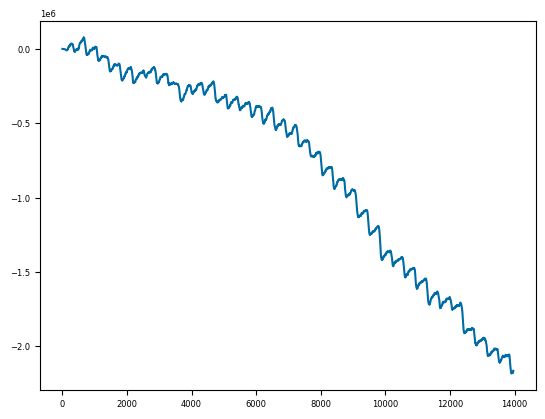

In [474]:
df.cumsum()["Rate of ice sheet mass change (Gt/yr)"].plot()

In [490]:
s_df = df[time["Date"] > "1992"]
s_time = time[time["Date"] > "1992"]
s_df["Cumulative ice sheet mass change (Gt)"] = (
        s_df["Rate of ice sheet mass change (Gt/yr)"].divide(365).cumsum()
    )


/var/folders/pb/9bmdq04j7h9126gzz9zd3b_80000gn/T/ipykernel_33694/2000912641.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s_df["Cumulative ice sheet mass change (Gt)"] = (


<Axes: >

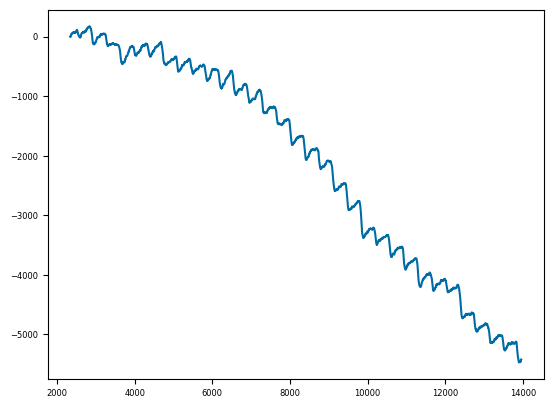

In [491]:
s_df["Cumulative ice sheet mass change (Gt)"].plot()

In [489]:
days_of_year

array([366, 365, 365, ..., 365, 365, 365])

In [492]:
    df = pd.read_csv(url, parse_dates=["time"], infer_datetime_format=True)

    df = df.rename(
        columns={
            "time": "Date",
            "MB": "Rate of ice sheet mass change (Gt/yr)",
            "SMB": "Rate of surface mass balance (Gt/yr)",
            "D": "Rate of ice discharge (Gt/yr)",
            "MB_err": "Rate of ice sheet mass change uncertainty (Gt/yr)",
            "SMB_err": "Rate of surface mass balance uncertainty (Gt/yr)",
            "D_err": "Rate of ice discharge uncertainty (Gt/yr)",
        }
    )

    sec_per_day = 24 * 60**2
    days_per_year = np.where(df["Date"].dt.is_leap_year, 366, 365)
    time = df[["Date"]]
    time["delta"] = 1
    time["delta"][df["Date"] < "1986-01-01"] = days_of_year[df["Date"] < "1986-01-01"]
    df = df[
        [
            "Rate of ice sheet mass change (Gt/day)",
            "Rate of surface mass balance (Gt/day)",
            "Rate of ice discharge (Gt/day)",
            "Rate of ice sheet mass change uncertainty (Gt/day)",
            "Rate of surface mass balance uncertainty (Gt/day)",
            "Rate of ice discharge uncertainty (Gt/day)",
        ]
    ]
    # df = df.set_index(time["Date"]).resample("1D").mean().ffill().reset_index(drop=True)
    df["Cumulative ice sheet mass change (Gt)"] = df[
        "Rate of ice sheet mass change (Gt/day)"
    ].cumsum()
    df["Cumulative ice discharge anomaly (Gt)"] = df[
        "Rate of ice discharge (Gt/day)"
    ].cumsum()
    df["Cumulative surface mass balance anomaly (Gt)"] = df[
        "Rate of surface mass balance (Gt/day)"
    ].cumsum()
    df["Cumulative ice sheet mass change uncertainty (Gt)"] = (
        df["Rate of ice sheet mass change uncertainty (Gt/day)"]
        .apply(np.square)
        .cumsum()
        .apply(np.sqrt)
    )
    df["Cumulative surface mass balance anomaly uncertainty (Gt)"] = (
        df["Rate of surface mass balance uncertainty (Gt/day)"]
        .apply(np.square)
        .cumsum()
        .apply(np.sqrt)
    )
    df["Cumulative ice discharge anomaly uncertainty (Gt)"] = (
        df["Rate of ice discharge uncertainty (Gt/day)"]
        .apply(np.square)
        .cumsum()
        .apply(np.sqrt)
    )
    df["Rate of ice sheet mass balance (Gt/yr)"] = df[
        "Rate of ice sheet mass balance (Gt/day)"
    ].multiply(days_per_year)
    df["Rate of ice discharge (Gt/yr)"] = df[
        "Rate of ice discharge (Gt/day)"
    ].multiply(days_per_year)
    df["Rate of surface mass balance (Gt/yr)"] = df[
        "Rate of surface mass balance (Gt/day)"
    ].multiply(days_per_year)
    df = pd.merge(df, time, left_index=True, right_index=True)


/var/folders/pb/9bmdq04j7h9126gzz9zd3b_80000gn/T/ipykernel_33694/1683272594.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time["delta"] = 1
/var/folders/pb/9bmdq04j7h9126gzz9zd3b_80000gn/T/ipykernel_33694/1683272594.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time["delta"][df["Date"] < "1986-01-01"] = days_of_year[df["Date"] < "1986-01-01"]


KeyError: "None of [Index(['Rate of ice sheet mass change (Gt/day)',\n       'Rate of surface mass balance (Gt/day)',\n       'Rate of ice discharge (Gt/day)',\n       'Rate of ice sheet mass change uncertainty (Gt/day)',\n       'Rate of surface mass balance uncertainty (Gt/day)',\n       'Rate of ice discharge uncertainty (Gt/day)'],\n      dtype='object')] are in the [columns]"

In [493]:
    df = pd.read_csv(url, parse_dates=["time"], infer_datetime_format=True)

    df = df.rename(
        columns={
            "time": "Date",
            "MB": "Rate of ice sheet mass change (Gt/day)",
            "SMB": "Rate of surface mass balance (Gt/day)",
            "D": "Rate of ice discharge (Gt/day)",
            "MB_err": "Rate of ice sheet mass change uncertainty (Gt/day)",
            "SMB_err": "Rate of surface mass balance uncertainty (Gt/day)",
            "D_err": "Rate of ice discharge uncertainty (Gt/day)",
        }
    )

    sec_per_day = 24 * 60**2
    days_per_year = np.where(df["Date"].dt.is_leap_year, 366, 365)
    time = df[["Date"]]
    time["delta"] = 1
    time["delta"][df["Date"] < "1986-01-01"] = days_of_year[df["Date"] < "1986-01-01"]
    df = df[
        [
            "Rate of ice sheet mass change (Gt/day)",
            "Rate of surface mass balance (Gt/day)",
            "Rate of ice discharge (Gt/day)",
            "Rate of ice sheet mass change uncertainty (Gt/day)",
            "Rate of surface mass balance uncertainty (Gt/day)",
            "Rate of ice discharge uncertainty (Gt/day)",
        ]
    ]
    # df = df.set_index(time["Date"]).resample("1D").mean().ffill().reset_index(drop=True)
    df["Cumulative ice sheet mass change (Gt)"] = df[
        "Rate of ice sheet mass change (Gt/day)"
    ].cumsum()
    df["Cumulative ice discharge anomaly (Gt)"] = df[
        "Rate of ice discharge (Gt/day)"
    ].cumsum()
    df["Cumulative surface mass balance anomaly (Gt)"] = df[
        "Rate of surface mass balance (Gt/day)"
    ].cumsum()
    df["Cumulative ice sheet mass change uncertainty (Gt)"] = (
        df["Rate of ice sheet mass change uncertainty (Gt/day)"]
        .apply(np.square)
        .cumsum()
        .apply(np.sqrt)
    )
    df["Cumulative surface mass balance anomaly uncertainty (Gt)"] = (
        df["Rate of surface mass balance uncertainty (Gt/day)"]
        .apply(np.square)
        .cumsum()
        .apply(np.sqrt)
    )
    df["Cumulative ice discharge anomaly uncertainty (Gt)"] = (
        df["Rate of ice discharge uncertainty (Gt/day)"]
        .apply(np.square)
        .cumsum()
        .apply(np.sqrt)
    )
    df["Rate of ice sheet mass balance (Gt/yr)"] = df[
        "Rate of ice sheet mass balance (Gt/day)"
    ].multiply(days_per_year)
    df["Rate of ice discharge (Gt/yr)"] = df["Rate of ice discharge (Gt/day)"].multiply(
        days_per_year
    )
    df["Rate of surface mass balance (Gt/yr)"] = df[
        "Rate of surface mass balance (Gt/day)"
    ].multiply(days_per_year)


/var/folders/pb/9bmdq04j7h9126gzz9zd3b_80000gn/T/ipykernel_33694/4153515160.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time["delta"] = 1
/var/folders/pb/9bmdq04j7h9126gzz9zd3b_80000gn/T/ipykernel_33694/4153515160.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time["delta"][df["Date"] < "1986-01-01"] = days_of_year[df["Date"] < "1986-01-01"]


KeyError: 'Rate of ice sheet mass balance (Gt/day)'

In [519]:
def load_mankoff(
    url: Union[str, Path] = Path(
        "/Users/andy/Google Drive/My Drive/Projects/RAGIS/data/MB_SMB_D_BMB.csv"
    ),
    norm_year: Union[None, float] = None,
) -> pd.DataFrame:
    df = pd.read_csv(url, parse_dates=["time"], infer_datetime_format=True)

    df = df.rename(
        columns={
            "time": "Date",
            "MB": "Rate of ice sheet mass change (Gt/day)",
            "SMB": "Rate of surface mass balance (Gt/day)",
            "D": "Rate of ice discharge (Gt/day)",
            "MB_err": "Rate of ice sheet mass change uncertainty (Gt/day)",
            "SMB_err": "Rate of surface mass balance uncertainty (Gt/day)",
            "D_err": "Rate of ice discharge uncertainty (Gt/day)",
        }
    )

    sec_per_day = 24 * 60**2
    days_per_year = np.where(df["Date"].dt.is_leap_year, 366, 365)
    df["delta"] = df[["Date"]]
    df["delta"] = 1
    df["delta"][df["Date"] < "1986-01-01"] = days_of_year[df["Date"] < "1986-01-01"]
    df = df[
        [
            "Date",
            "delta",
            "Rate of ice sheet mass change (Gt/day)",
            "Rate of surface mass balance (Gt/day)",
            "Rate of ice discharge (Gt/day)",
            "Rate of ice sheet mass change uncertainty (Gt/day)",
            "Rate of surface mass balance uncertainty (Gt/day)",
            "Rate of ice discharge uncertainty (Gt/day)",
        ]
    ]
    # df = df.set_index(time["Date"]).resample("1D").mean().ffill().reset_index(drop=True)
    df["Cumulative ice sheet mass change (Gt)"] = (
        df["Rate of ice sheet mass change (Gt/day)"].multiply(df["delta"]).cumsum()
    )
    df["Cumulative ice discharge anomaly (Gt)"] = (
        df["Rate of ice discharge (Gt/day)"].multiply(df["delta"]).cumsum()
    )
    df["Cumulative surface mass balance anomaly (Gt)"] = (
        df["Rate of surface mass balance (Gt/day)"].multiply(df["delta"]).cumsum()
    )
    df["Cumulative ice sheet mass change uncertainty (Gt)"] = (
        df["Rate of ice sheet mass change uncertainty (Gt/day)"]
        .apply(np.square)
        .cumsum()
        .apply(np.sqrt)
    )
    df["Cumulative surface mass balance anomaly uncertainty (Gt)"] = (
        df["Rate of surface mass balance uncertainty (Gt/day)"]
        .apply(np.square)
        .cumsum()
        .apply(np.sqrt)
    )
    df["Cumulative ice discharge anomaly uncertainty (Gt)"] = (
        df["Rate of ice discharge uncertainty (Gt/day)"]
        .apply(np.square)
        .cumsum()
        .apply(np.sqrt)
    )
    df["Rate of ice sheet mass change (Gt/yr)"] = df[
        "Rate of ice sheet mass change (Gt/day)"
    ].multiply(days_per_year)
    df["Rate of ice discharge (Gt/yr)"] = df["Rate of ice discharge (Gt/day)"].multiply(
        days_per_year
    )
    df["Rate of surface mass balance (Gt/yr)"] = df[
        "Rate of surface mass balance (Gt/day)"
    ].multiply(days_per_year)
    df["Year"] = [to_decimal_year(d) for d in df["Date"]]

    cmSLE = 1.0 / 362.5 / 10.0
    df["SLE (cm)"] = df["Cumulative ice sheet mass change (Gt)"] * cmSLE
    df["SLE uncertainty (cm)"] = (
        df["Cumulative ice sheet mass change uncertainty (Gt)"] * cmSLE
    )
    if norm_year:
        # Normalize
        for v in [
            "Cumulative ice sheet mass change (Gt)",
            "Cumulative surface mass balance anomaly (Gt)",
            "Cumulative ice discharge anomaly (Gt)",
            "Cumulative ice sheet mass change uncertainty (Gt)",
            "Cumulative surface mass balance anomaly uncertainty (Gt)",
            "Cumulative ice discharge anomaly uncertainty (Gt)",
        ]:
            df[v] -= df[df["Year"] == norm_year][v].values

    return df


In [520]:
m = load_mankoff()

/var/folders/pb/9bmdq04j7h9126gzz9zd3b_80000gn/T/ipykernel_33694/3964805097.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["delta"][df["Date"] < "1986-01-01"] = days_of_year[df["Date"] < "1986-01-01"]


<Axes: xlabel='Date', ylabel='Cumulative ice sheet mass change (Gt)'>

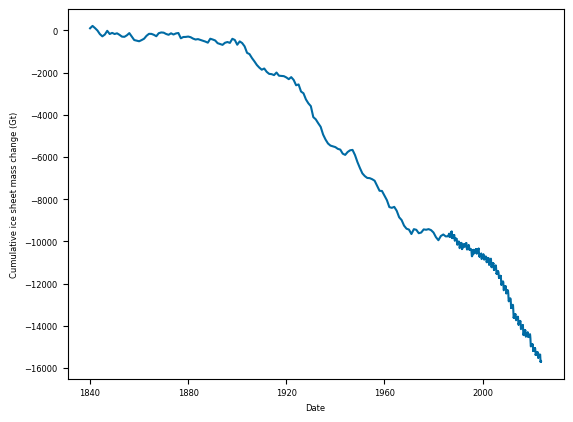

In [521]:
sns.lineplot(m, x="Date", y="Cumulative ice sheet mass change (Gt)")

<Axes: xlabel='Date', ylabel='Rate of ice sheet mass change (Gt/day)'>

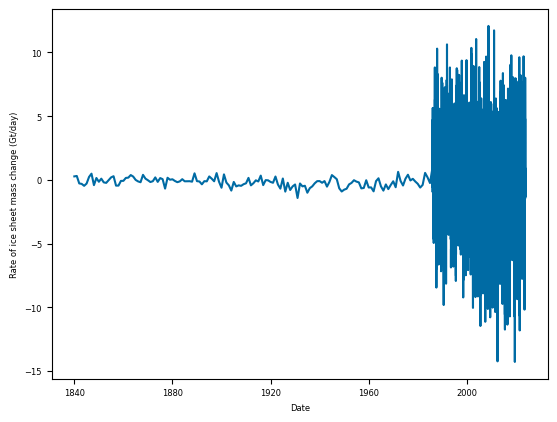

In [524]:
sns.lineplot(m.reset_index(), x="Date", y="Rate of ice sheet mass change (Gt/day)")

<Axes: xlabel='Date'>

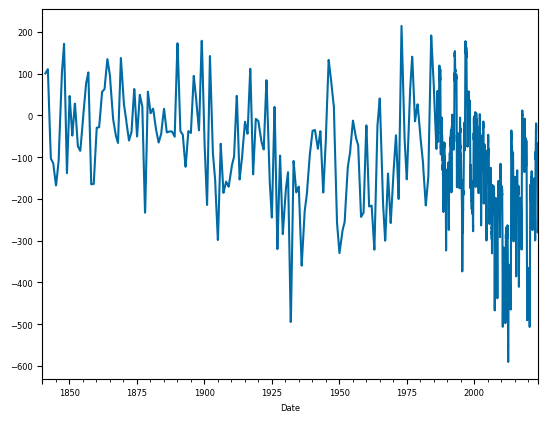

In [536]:
k = m.set_index("Date").resample("1D").mean().ffill()
k.rolling(390).mean()["Rate of ice sheet mass change (Gt/yr)"].plot()

In [525]:
df

,Rate of ice sheet mass change (Gt/day),Rate of surface mass balance (Gt/day),Rate of ice discharge (Gt/day),Rate of ice sheet mass change uncertainty (Gt/day),Rate of surface mass balance uncertainty (Gt/day),Rate of ice discharge uncertainty (Gt/day),Cumulative ice sheet mass change (Gt),Cumulative ice discharge anomaly (Gt),Cumulative surface mass balance anomaly (Gt),Cumulative ice sheet mass change uncertainty (Gt),Cumulative surface mass balance anomaly uncertainty (Gt),Cumulative ice discharge anomaly uncertainty (Gt),Rate of ice sheet mass change (Gt/yr),Rate of ice discharge (Gt/yr),Rate of surface mass balance (Gt/yr),Date,delta
0,0.272769,1.407972,1.073991,0.372525,0.302918,0.213435,99.833454,393.080706,515.317752,0.372525,0.302918,0.213435,99.833454,393.080706,515.317752,1840-01-01,366
1,0.305809,1.438253,1.073991,0.356626,0.284199,0.212174,211.453739,785.087421,1040.280097,0.515710,0.415365,0.300952,111.620285,392.006715,524.962345,1841-01-01,365
2,-0.278525,0.857085,1.073991,0.356369,0.281043,0.215736,109.792114,1177.094136,1353.116122,0.626862,0.501511,0.370290,-101.661625,392.006715,312.836025,1842-01-01,365
3,-0.315155,0.822635,1.073991,0.371316,0.301422,0.213270,-5.239461,1569.100851,1653.377897,0.728582,0.585123,0.427315,-115.031575,392.006715,300.261775,1843-01-01,365
4,-0.467526,0.670860,1.073991,0.368980,0.298957,0.212640,-176.353977,1962.181557,1898.912657,0.816687,0.657072,0.477299,-171.114516,393.080706,245.534760,1844-01-01,366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13955,-0.498719,0.895965,1.346674,0.228667,0.080637,0.213524,-15662.976504,79380.321628,68115.235934,33.262641,30.056217,14.124879,-182.032435,491.536010,327.027225,2023-10-23,1
13956,-0.756204,0.638560,1.346756,0.222692,0.057470,0.214697,-15663.732708,79381.668384,68115.874494,33.263386,30.056272,14.126511,-276.014460,491.565940,233.074400,2023-10-24,1
13957,-0.812820,0.582069,1.346885,0.222573,0.052386,0.215871,-15664.545528,79383.015269,68116.456563,33.264131,30.056318,14.128160,-296.679300,491.613025,212.455185,2023-10-25,1
13958,-0.518661,0.876372,1.347028,0.231351,0.078873,0.217045,-15665.064189,79384.362297,68117.332935,33.264935,30.056421,14.129827,-189.311265,491.665220,319.875780,2023-10-26,1
